# Sentiment Analysis with RNN and LSTM

Student Name: Rojan Dhungel
Student ID: 2329254

This notebook implements a sentiment analysis system for financial phrases or tweets, classifying them as **Negative**, **Neutral**, or **Positive**. It includes three models: Simple RNN with trainable Embedding, LSTM with trainable Embedding, and LSTM with pretrained Word2Vec embeddings. The pipeline covers data preprocessing, tokenization, model training, evaluation with independent visualizations, and a Gradio interface for real-time predictions.

## Objectives
- Load and preprocess a dataset of financial phrases.
- Tokenize and prepare data for RNN/LSTM models.
- Build and train three models:
  1. Simple RNN with trainable Embedding.
  2. LSTM with trainable Embedding.
  3. LSTM with pretrained Word2Vec embeddings.
- Evaluate models with independent visualizations (confusion matrix, classification metrics, accuracy comparison).
- Provide a Gradio interface for real-time predictions.

## Libraries Used
- `pandas`, `numpy`: Data handling.
- `nltk`, `re`, `contractions`: Text preprocessing.
- `seaborn`, `matplotlib`: Visualization.
- `tensorflow`: Model training and inference.
- `gradio`: User interface.
- `wordcloud`: Word cloud generation.
- `gensim`: Pretrained Word2Vec embeddings.

In [1]:
# Configure environment for clean output
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)  # Suppress deprecation warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging

## Install Dependencies

Install required libraries quietly to avoid cluttering the output.

In [2]:
# Uninstall conflicting packages to start fresh
!pip uninstall -y tensorflow numpy pandas protobuf ml_dtypes --quiet

# Install compatible versions
!pip install tensorflow==2.18.0 numpy==1.26.4 pandas==2.2.3 protobuf>=5.26.1 ml_dtypes>=0.4.0 contractions gensim wordcloud gradio --quiet

# Install additional dependencies for compatibility
!pip install scikit-learn matplotlib seaborn nltk --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


## Import Libraries

Import libraries for data processing, modeling, visualization, and user interface creation.

In [3]:
# Import libraries for data processing, modeling, and visualization
import pandas as pd
import numpy as np
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import gensim.downloader as api
import gradio as gr

## Download NLTK Resources

Download NLTK resources for tokenization, stopword removal, and lemmatization.

In [4]:
# Download required NLTK resources
nltk.download('punkt', quiet=True)  # Tokenization
nltk.download('stopwords', quiet=True)  # Stopwords
nltk.download('wordnet', quiet=True)  # Lemmatization
nltk.download('punkt_tab', quiet=True)  # Additional tokenization support

True

## Mount Google Drive

Mount Google Drive to access the dataset.

In [5]:
# Mount Google Drive for dataset access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define Preprocessing Function

Define a function to preprocess text, including lowercasing, expanding contractions, removing noise, and lemmatizing.

In [6]:
def preprocess_text(raw_text):
    """Preprocess a raw text input for sentiment analysis.

    Args:
        raw_text (str): The raw text to preprocess.

    Returns:
        str: Cleaned and lemmatized text.

    Raises:
        Exception: If preprocessing fails.
    """
    try:
        # Convert text to lowercase
        raw_text = str(raw_text).lower()

        # Expand contractions
        raw_text = contractions.fix(raw_text)

        # Remove URLs, mentions, hashtags, and special characters
        raw_text = re.sub(r'http\S+|www\S+|https\S+', '', raw_text, flags=re.MULTILINE)
        raw_text = re.sub(r'@\w+|#\w+', '', raw_text)
        raw_text = re.sub(r'[^a-zA-Z\s]', '', raw_text)

        # Initialize stopwords and lemmatizer
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()

        # Tokenize text
        tokens = word_tokenize(raw_text)

        # Remove stopwords and lemmatize tokens
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        # Join tokens into a string
        return ' '.join(tokens)

    except Exception as e:
        # Log preprocessing error
        print(f"Error preprocessing text: {e}")
        return ''

## Load and Preprocess Dataset

Define a function to load and preprocess the dataset, including sentiment encoding and text cleaning.

In [7]:
def import_and_prepare_dataset(dataset_path):
    """Load and preprocess the dataset for sentiment analysis.

    Args:
        dataset_path (str): Path to the CSV file containing the dataset.

    Returns:
        pandas.DataFrame: Preprocessed dataset with cleaned text and encoded labels.

    Raises:
        ValueError: If 'text' or 'label' columns are missing.
        Exception: If dataset loading fails.
    """
    try:
        # Load dataset using pandas
        dataset = pd.read_csv(dataset_path)

        # Verify required columns
        if 'text' not in dataset.columns or 'label' not in dataset.columns:
            raise ValueError("Dataset must include 'text' and 'label' columns.")

        # Encode sentiment labels
        sentiment_encoding = {'positive': 2, 'neutral': 1, 'negative': 0}
        dataset['label'] = dataset['label'].map(sentiment_encoding)

        # Handle missing text values
        dataset['text'] = dataset['text'].fillna('')

        # Apply preprocessing to text column
        dataset['cleaned_text'] = dataset['text'].apply(preprocess_text)

        return dataset

    except Exception as e:
        # Log dataset loading error
        print(f"Error loading dataset: {e}")
        raise

## Execute Dataset Loading

Load the dataset from Google Drive and preprocess it.

In [8]:
# Load and preprocess dataset
try:
    dataset_path = "/content/drive/MyDrive/AIML/RNN_Final/financial_phrase.csv"
    dataset = import_and_prepare_dataset(dataset_path)
except Exception as e:
    # Log preprocessing error
    print(f"Failed to preprocess dataset: {e}")
    raise

## Visualize Class Distribution

Plot the distribution of sentiment classes with an enhanced aesthetic.

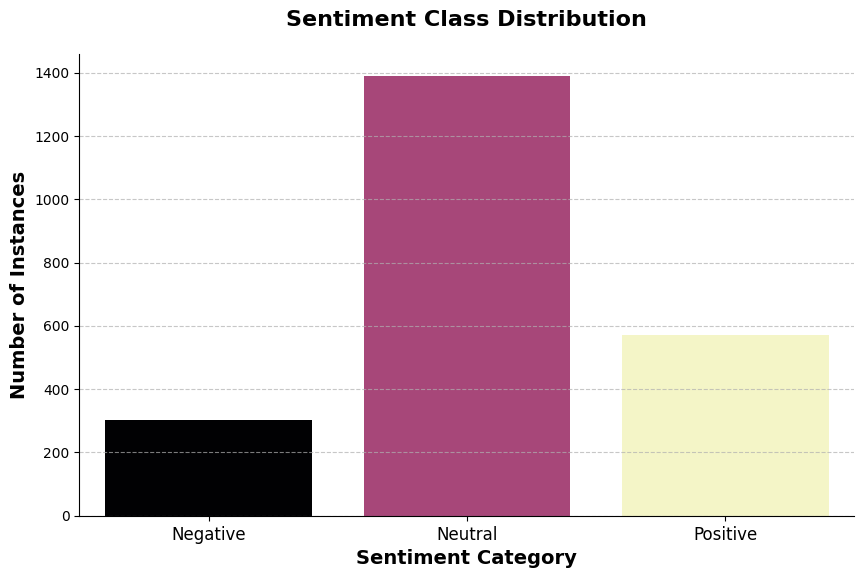

In [9]:
# Visualize sentiment class distribution
try:
    # Create a figure with specified size
    plt.figure(figsize=(10, 6))

    # Plot countplot with vibrant colors
    sns.countplot(x='label', data=dataset, palette='magma', hue='label', legend=False)

    # Customize x-axis labels
    plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], fontsize=12)

    # Set title and labels with bold fonts
    plt.title('Sentiment Class Distribution', fontsize=16, weight='bold', pad=20)
    plt.xlabel('Sentiment Category', fontsize=14, weight='bold')
    plt.ylabel('Number of Instances', fontsize=14, weight='bold')

    # Add grid for readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Customize plot spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Display the plot
    plt.show()

except Exception as e:
    # Log visualization error
    print(f"Error in class distribution plot: {e}")

## Visualize Word Clouds by Sentiment

Generate word clouds for each sentiment (Negative, Neutral, Positive) to visualize the most frequent words in the cleaned text.

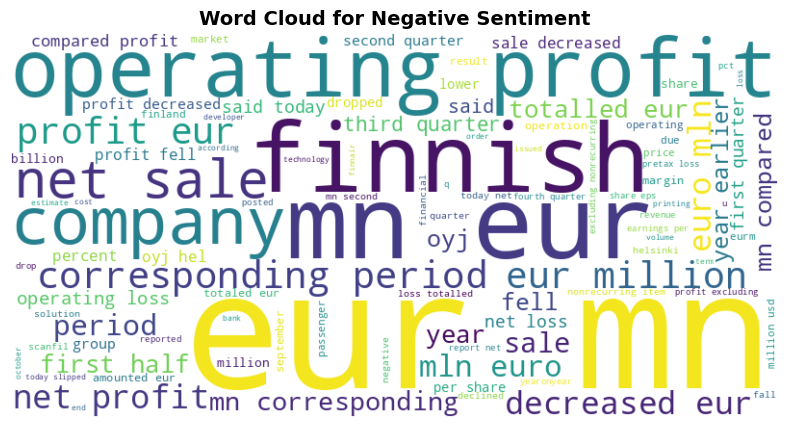

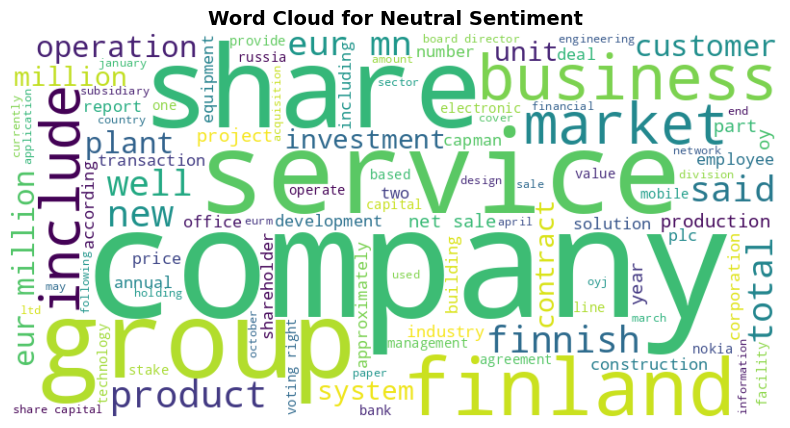

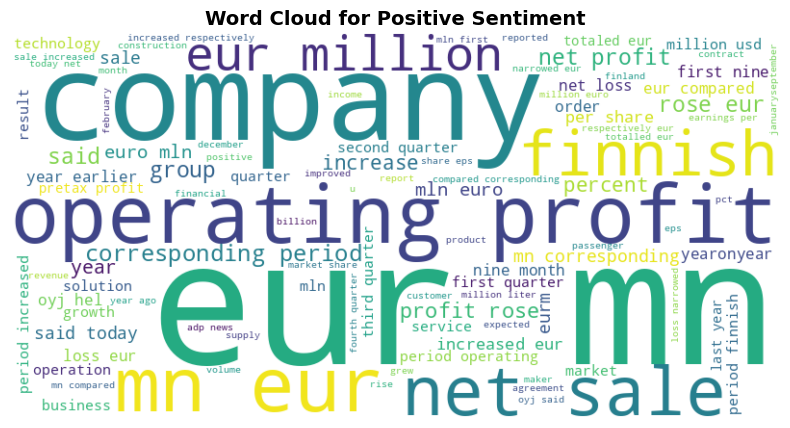

In [10]:
# Visualize word clouds for each sentiment
try:
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    for label in [0, 1, 2]:
        # Combine cleaned text for the sentiment
        text = ' '.join(dataset[dataset['label'] == label]['cleaned_text'])
        if not text.strip():
            print(f"No text available for {sentiment_map[label]} sentiment.")
            continue

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

        # Plot word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {sentiment_map[label]} Sentiment', fontsize=14, weight='bold')
        plt.show()

except Exception as e:
    # Log word cloud error
    print(f"Error generating word clouds: {e}")

## Visualize Most Frequent Words

Plot a bar chart of the top 20 most frequent words across all cleaned text.

<ipython-input-11-93baf415539c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='magma')


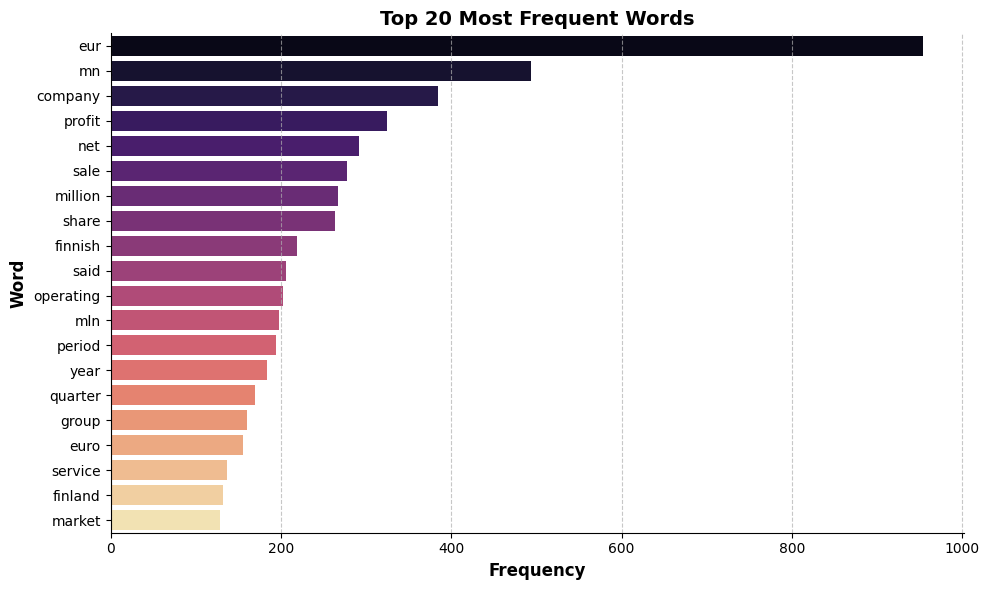

In [11]:
# Visualize most frequent words
try:
    from collections import Counter

    # Combine all cleaned text
    all_text = ' '.join(dataset['cleaned_text'])
    if not all_text.strip():
        raise ValueError("No text available for frequency analysis.")

    # Split into words and count frequencies
    words = all_text.split()
    word_freq = Counter(words).most_common(20)
    word_freq_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='magma')
    plt.title('Top 20 Most Frequent Words', fontsize=14, weight='bold')
    plt.xlabel('Frequency', fontsize=12, weight='bold')
    plt.ylabel('Word', fontsize=12, weight='bold')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

except Exception as e:
    # Log frequency plot error
    print(f"Error generating most frequent words plot: {e}")

## Tokenize and Prepare Data

Tokenize the cleaned text and prepare sequences for model training.

In [12]:
# Tokenize and prepare data for training
try:
    # Initialize tokenizer
    tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
    tokenizer.fit_on_texts(dataset['cleaned_text'])

    # Convert text to sequences
    sequences = tokenizer.texts_to_sequences(dataset['cleaned_text'])

    # Set maximum sequence length
    max_sequence_length = 100

    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

    # Prepare labels
    labels = dataset['label'].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, labels, test_size=0.2, random_state=42
    )

except Exception as e:
    # Log tokenization error
    print(f"Error in tokenization: {e}")
    raise

## Load Pretrained Word2Vec Embeddings

Load pretrained Word2Vec embeddings and create an embedding matrix.

In [13]:
# Load pretrained Word2Vec embeddings
try:
    # Load Word2Vec model
    word2vec = api.load('word2vec-google-news-300')

    # Initialize embedding matrix
    vocab_size = 10000
    embedding_dim = 300
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Populate embedding matrix
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            try:
                embedding_vector = word2vec[word]
                embedding_matrix[i] = embedding_vector
            except KeyError:
                continue

except Exception as e:
    # Log Word2Vec loading error
    print(f"Error loading Word2Vec embeddings: {e}")
    raise

## Define and Train Simple RNN Model

Define and train the Simple RNN model with trainable Embedding.

In [14]:
# Define model architecture functions
def build_simple_rnn():
    """Build a Simple RNN model with trainable Embedding.

    Returns:
        Model: Compiled Keras model.
    """
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_sequence_length),
        SimpleRNN(64, kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(3, activation='softmax')
    ])
    return model

## Define and Train LSTM with Trainable Embedding

Define and train the LSTM model with trainable Embedding.

In [15]:
def build_lstm_trainable():
    """Build an LSTM model with trainable Embedding.

    Returns:
        Model: Compiled Keras model.
    """
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_sequence_length),
        Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01))),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(3, activation='softmax')
    ])
    return model

## Define and Train LSTM with Word2Vec Embeddings

Define and train the LSTM model with pretrained Word2Vec embeddings.

In [16]:
def build_lstm_word2vec():
    """Build an LSTM model with pretrained Word2Vec embeddings.

    Returns:
        Model: Compiled Keras model.
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True),
        Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model

## Train Simple RNN Model

Train the Simple RNN model using the defined architecture.

In [17]:
# Train Simple RNN model
try:
    models = {}  # Initialize models dictionary
    simple_rnn_model = build_simple_rnn()
    simple_rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = simple_rnn_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=7)],
    verbose=1
)
    models['Simple RNN'] = simple_rnn_model
except Exception as e:
    # Log model training error
    print(f"Error training Simple RNN model: {e}")
    raise

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.4492 - loss: 2.1870 - val_accuracy: 0.6226 - val_loss: 1.7456
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6171 - loss: 1.6468 - val_accuracy: 0.6226 - val_loss: 1.4214
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6095 - loss: 1.3690 - val_accuracy: 0.6226 - val_loss: 1.2609
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6055 - loss: 1.2188 - val_accuracy: 0.6143 - val_loss: 1.1953
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.6582 - loss: 1.0846 - val_accuracy: 0.5730 - val_loss: 1.1725
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7228 - loss: 0.9198 - val_accuracy: 0.4628 - val_loss: 1.3311
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7281 - loss: 0.8382 - val_accuracy: 0.5785 - val_loss: 1.2000
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8115 - loss: 0.6528 - val_accuracy: 0.4959 - v

## Train LSTM with Trainable Embedding

Train the LSTM model with trainable Embedding using the defined architecture.

In [18]:
# Train LSTM model with trainable Embedding
try:
    lstm_model = build_lstm_trainable()
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    lstm_trainable_history = lstm_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=7)],
        verbose=1
    )
    models['LSTM Trainable'] = lstm_model
except Exception as e:
    print(f"Error training LSTM Trainable model: {e}")
    raise

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.5466 - loss: 4.0813 - val_accuracy: 0.6226 - val_loss: 2.1498
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6891 - loss: 1.7840 - val_accuracy: 0.7273 - val_loss: 1.0993
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.7966 - loss: 0.8941 - val_accuracy: 0.7466 - val_loss: 0.7729
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.8472 - loss: 0.5762 - val_accuracy: 0.7658 - val_loss: 0.6616
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.8461 - loss: 0.4685 - val_accuracy: 0.7658 - val_loss: 0.6285
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.8583 - loss: 0.4102 - val_accuracy: 0.7658 - val_loss: 0.6181
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.8678 - loss: 0.3727 - val_accuracy: 0.7713 - val_loss: 0.6232
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.8586 - loss: 0.3406 - val_accura

## Train LSTM with Word2Vec Embeddings

Train the LSTM model with pretrained Word2Vec embeddings using the defined architecture.

In [19]:
# Train LSTM model with Word2Vec embeddings
try:
    word2vec_lstm_model = build_lstm_word2vec()
    word2vec_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    lstm_word2vec_history = word2vec_lstm_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=7)],
        verbose=1
    )
    models['LSTM Word2Vec'] = word2vec_lstm_model
except Exception as e:
    print(f"Error training LSTM Word2Vec model: {e}")
    raise

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 584ms/step - accuracy: 0.6339 - loss: 7.0708 - val_accuracy: 0.7466 - val_loss: 2.3759
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 575ms/step - accuracy: 0.7572 - loss: 1.8159 - val_accuracy: 0.7576 - val_loss: 0.9959
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 606ms/step - accuracy: 0.8116 - loss: 0.8119 - val_accuracy: 0.7686 - val_loss: 0.8002
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 27s 581ms/step - accuracy: 0.8312 - loss: 0.5512 - val_accuracy: 0.7934 - val_loss: 0.6077
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 657ms/step - accuracy: 0.8468 - loss: 0.4350 - val_accuracy: 0.7796 - val_loss: 0.6158
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 558ms/step - accuracy: 0.8809 - loss: 0.3627 - val_accuracy: 0.8017 - val_loss: 0.5999
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 554ms/step - accuracy: 0.8971 - loss: 0.3248 - val_accuracy: 0.8154 - val_loss: 0.5743
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 544ms/step - accuracy: 0.9293 - loss: 0.2859 - val_accu

## Evaluate and Visualize Simple RNN Performance

Evaluate the Simple RNN model on the test set and generate visualizations:
- **Confusion Matrix**: Heatmap of predicted vs. actual labels.
- **Classification Metrics**: Bar plots for precision, recall, and F1-score per class.

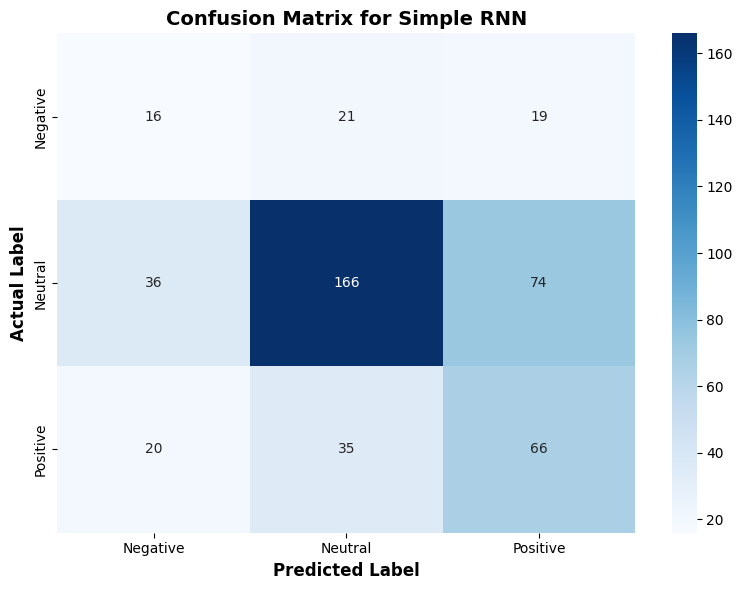

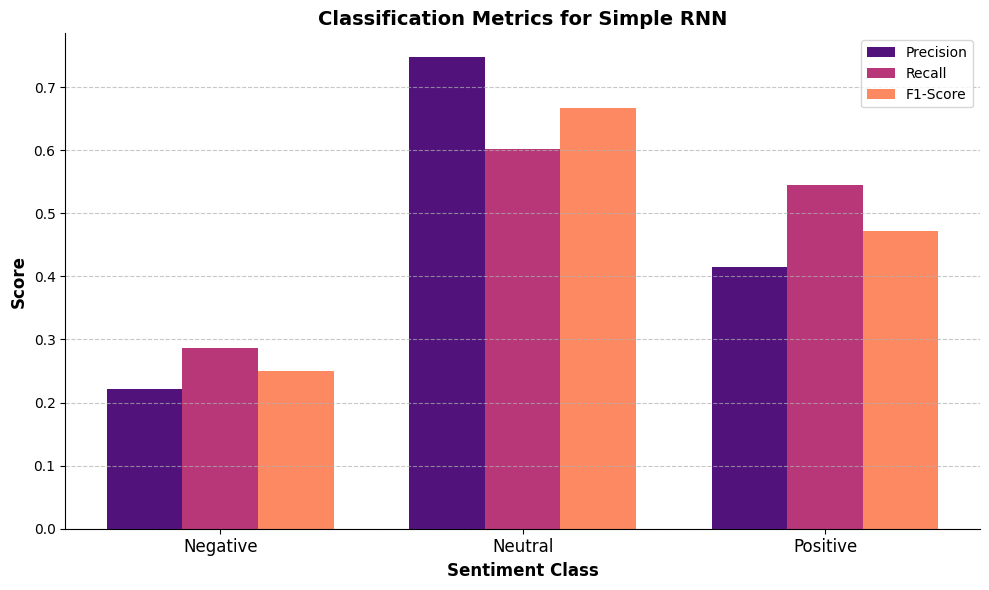


Classification Report for Simple RNN:

              precision    recall  f1-score   support

    Negative       0.22      0.29      0.25        56
     Neutral       0.75      0.60      0.67       276
    Positive       0.42      0.55      0.47       121

    accuracy                           0.55       453
   macro avg       0.46      0.48      0.46       453
weighted avg       0.59      0.55      0.56       453



In [20]:
# Evaluate and visualize Simple RNN performance
try:
    model_name = 'Simple RNN'
    model = models[model_name]

    # Predict on test set
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    # Calculate accuracy for later comparison
    accuracy = accuracy_score(y_test, y_pred)
    if not hasattr(globals(), 'model_accuracies'):
        model_accuracies = {}
    model_accuracies[model_name] = accuracy

    # --- Visualization 1: Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=12, weight='bold')
    plt.ylabel('Actual Label', fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- Visualization 2: Classification Metrics ---
    # Get classification report as dictionary
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

    # Extract precision, recall, and F1-score
    metrics = {'precision': [], 'recall': [], 'f1-score': []}
    classes = ['Negative', 'Neutral', 'Positive']
    for cls in classes:
        metrics['precision'].append(report[cls]['precision'])
        metrics['recall'].append(report[cls]['recall'])
        metrics['f1-score'].append(report[cls]['f1-score'])

    # Create bar plot for metrics
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(classes))
    width = 0.25

    ax.bar(x - width, metrics['precision'], width, label='Precision', color=sns.color_palette('magma', 3)[0])
    ax.bar(x, metrics['recall'], width, label='Recall', color=sns.color_palette('magma', 3)[1])
    ax.bar(x + width, metrics['f1-score'], width, label='F1-Score', color=sns.color_palette('magma', 3)[2])

    ax.set_xticks(x)
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_title(f'Classification Metrics for {model_name}', fontsize=14, weight='bold')
    ax.set_xlabel('Sentiment Class', fontsize=12, weight='bold')
    ax.set_ylabel('Score', fontsize=12, weight='bold')
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

except Exception as e:
    # Log evaluation error
    print(f"Error evaluating {model_name}: {e}")

## Evaluate and Visualize LSTM Trainable Performance

Evaluate the LSTM model with trainable Embedding on the test set and generate visualizations:
- **Confusion Matrix**: Heatmap of predicted vs. actual labels.
- **Classification Metrics**: Bar plots for precision, recall, and F1-score per class.

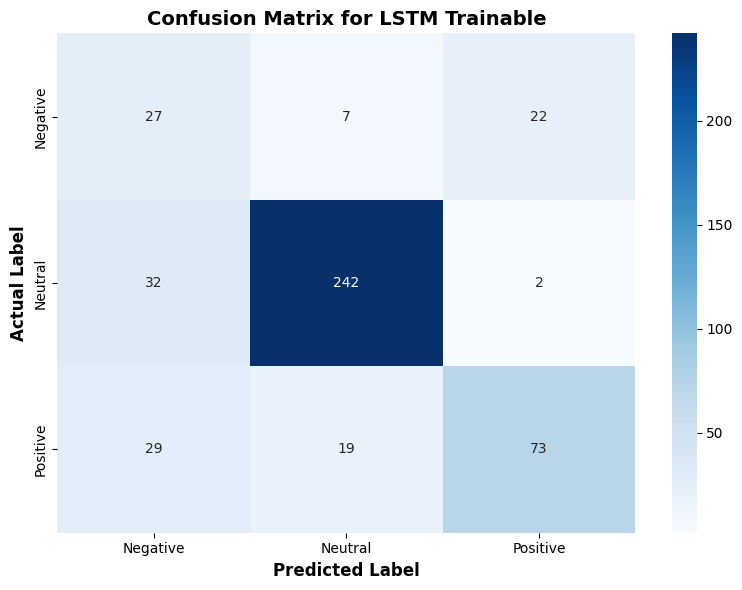

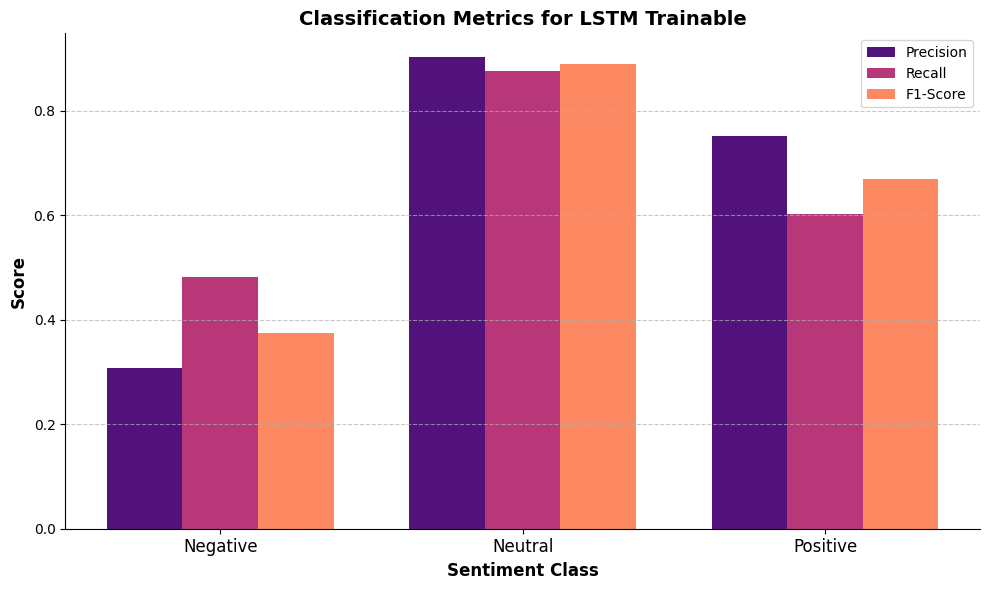


Classification Report for LSTM Trainable:

              precision    recall  f1-score   support

    Negative       0.31      0.48      0.38        56
     Neutral       0.90      0.88      0.89       276
    Positive       0.75      0.60      0.67       121

    accuracy                           0.75       453
   macro avg       0.65      0.65      0.64       453
weighted avg       0.79      0.75      0.77       453



In [21]:
# Evaluate and visualize LSTM Trainable performance
try:
    model_name = 'LSTM Trainable'
    model = models[model_name]

    # Predict on test set
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    # Calculate accuracy for later comparison
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy

    # --- Visualization 1: Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=12, weight='bold')
    plt.ylabel('Actual Label', fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- Visualization 2: Classification Metrics ---
    # Get classification report as dictionary
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

    # Extract precision, recall, and F1-score
    metrics = {'precision': [], 'recall': [], 'f1-score': []}
    classes = ['Negative', 'Neutral', 'Positive']
    for cls in classes:
        metrics['precision'].append(report[cls]['precision'])
        metrics['recall'].append(report[cls]['recall'])
        metrics['f1-score'].append(report[cls]['f1-score'])

    # Create bar plot for metrics
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(classes))
    width = 0.25

    ax.bar(x - width, metrics['precision'], width, label='Precision', color=sns.color_palette('magma', 3)[0])
    ax.bar(x, metrics['recall'], width, label='Recall', color=sns.color_palette('magma', 3)[1])
    ax.bar(x + width, metrics['f1-score'], width, label='F1-Score', color=sns.color_palette('magma', 3)[2])

    ax.set_xticks(x)
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_title(f'Classification Metrics for {model_name}', fontsize=14, weight='bold')
    ax.set_xlabel('Sentiment Class', fontsize=12, weight='bold')
    ax.set_ylabel('Score', fontsize=12, weight='bold')
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

except Exception as e:
    # Log evaluation error
    print(f"Error evaluating {model_name}: {e}")

## Evaluate and Visualize LSTM Word2Vec Performance

Evaluate the LSTM model with Word2Vec embeddings on the test set and generate visualizations:
- **Confusion Matrix**: Heatmap of predicted vs. actual labels.
- **Classification Metrics**: Bar plots for precision, recall, and F1-score per class.

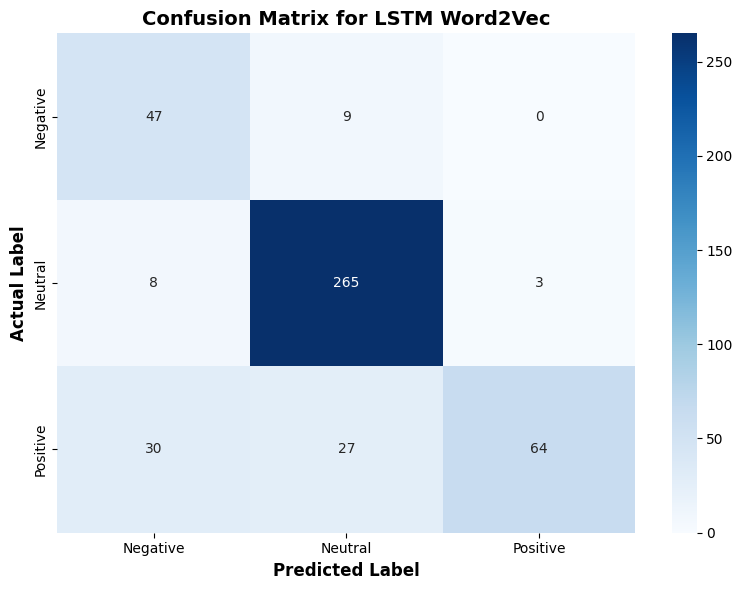

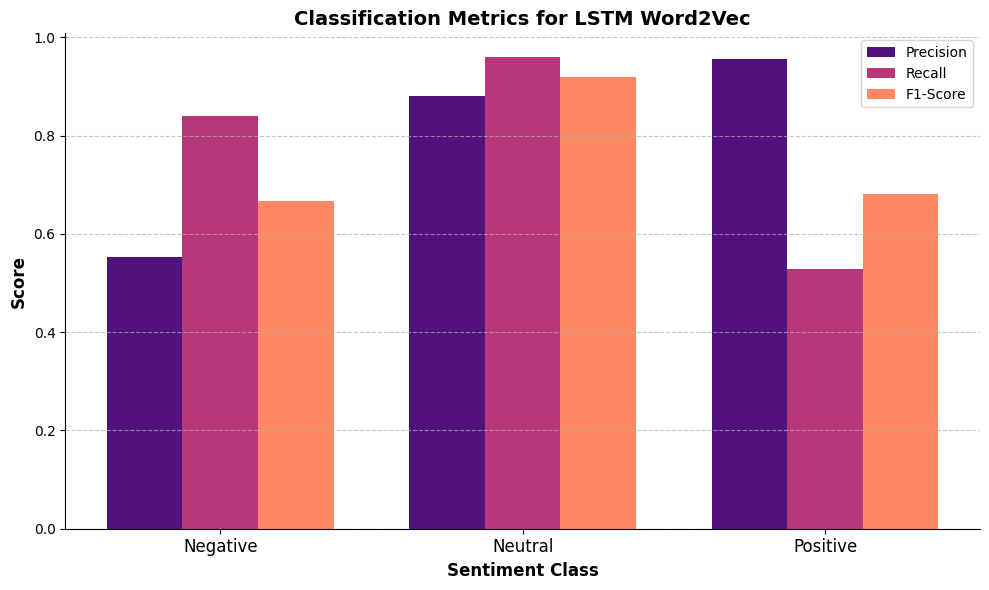


Classification Report for LSTM Word2Vec:

              precision    recall  f1-score   support

    Negative       0.55      0.84      0.67        56
     Neutral       0.88      0.96      0.92       276
    Positive       0.96      0.53      0.68       121

    accuracy                           0.83       453
   macro avg       0.80      0.78      0.76       453
weighted avg       0.86      0.83      0.82       453



In [22]:
# Evaluate and visualize LSTM Word2Vec performance
try:
    model_name = 'LSTM Word2Vec'
    model = models[model_name]

    # Predict on test set
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    # Calculate accuracy for later comparison
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy

    # --- Visualization 1: Confusion Matrix ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14, weight='bold')
    plt.xlabel('Predicted Label', fontsize=12, weight='bold')
    plt.ylabel('Actual Label', fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()

    # --- Visualization 2: Classification Metrics ---
    # Get classification report as dictionary
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

    # Extract precision, recall, and F1-score
    metrics = {'precision': [], 'recall': [], 'f1-score': []}
    classes = ['Negative', 'Neutral', 'Positive']
    for cls in classes:
        metrics['precision'].append(report[cls]['precision'])
        metrics['recall'].append(report[cls]['recall'])
        metrics['f1-score'].append(report[cls]['f1-score'])

    # Create bar plot for metrics
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(classes))
    width = 0.25

    ax.bar(x - width, metrics['precision'], width, label='Precision', color=sns.color_palette('magma', 3)[0])
    ax.bar(x, metrics['recall'], width, label='Recall', color=sns.color_palette('magma', 3)[1])
    ax.bar(x + width, metrics['f1-score'], width, label='F1-Score', color=sns.color_palette('magma', 3)[2])

    ax.set_xticks(x)
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_title(f'Classification Metrics for {model_name}', fontsize=14, weight='bold')
    ax.set_xlabel('Sentiment Class', fontsize=12, weight='bold')
    ax.set_ylabel('Score', fontsize=12, weight='bold')
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

except Exception as e:
    # Log evaluation error
    print(f"Error evaluating {model_name}: {e}")

## Compare Model Accuracies

Generate a bar plot comparing the test set accuracies of all models.

<ipython-input-23-847e16f237e4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_accuracies.values()), y=list(model_accuracies.keys()), palette='magma')


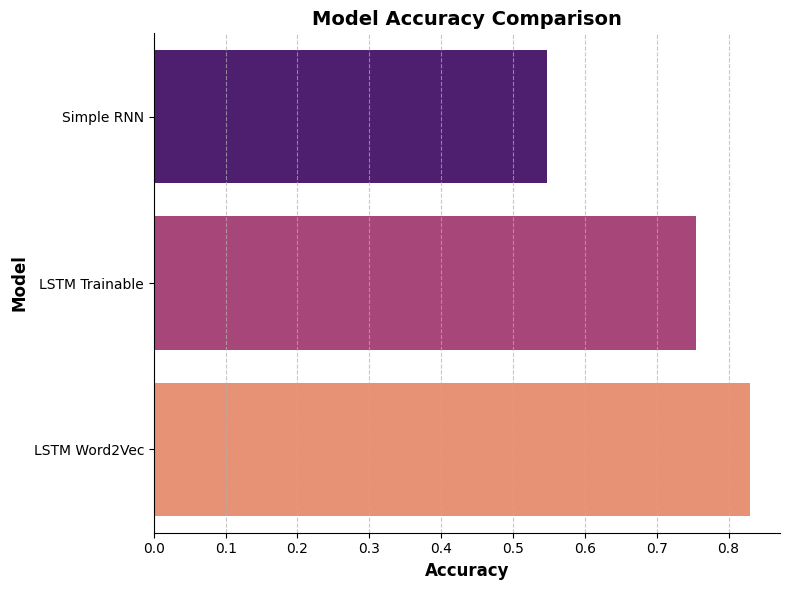

In [23]:
# Compare model accuracies
try:
    # Ensure model_accuracies is populated
    if not model_accuracies:
        raise ValueError("No model accuracies available. Run evaluation cells first.")

    # Create bar plot for accuracy comparison
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(model_accuracies.values()), y=list(model_accuracies.keys()), palette='magma')
    plt.title('Model Accuracy Comparison', fontsize=14, weight='bold')
    plt.xlabel('Accuracy', fontsize=12, weight='bold')
    plt.ylabel('Model', fontsize=12, weight='bold')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

except Exception as e:
    # Log comparison error
    print(f"Error in accuracy comparison: {e}")

In [33]:
# Print accuracy of all models
print("\nModel Accuracies:\n" + "-" * 20)
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name}: {accuracy * 100:.2f}%")



Model Accuracies:
--------------------
Simple RNN: 54.75%
LSTM Trainable: 75.50%
LSTM Word2Vec: 83.00%


## Simple RNN Model Train vs Validation



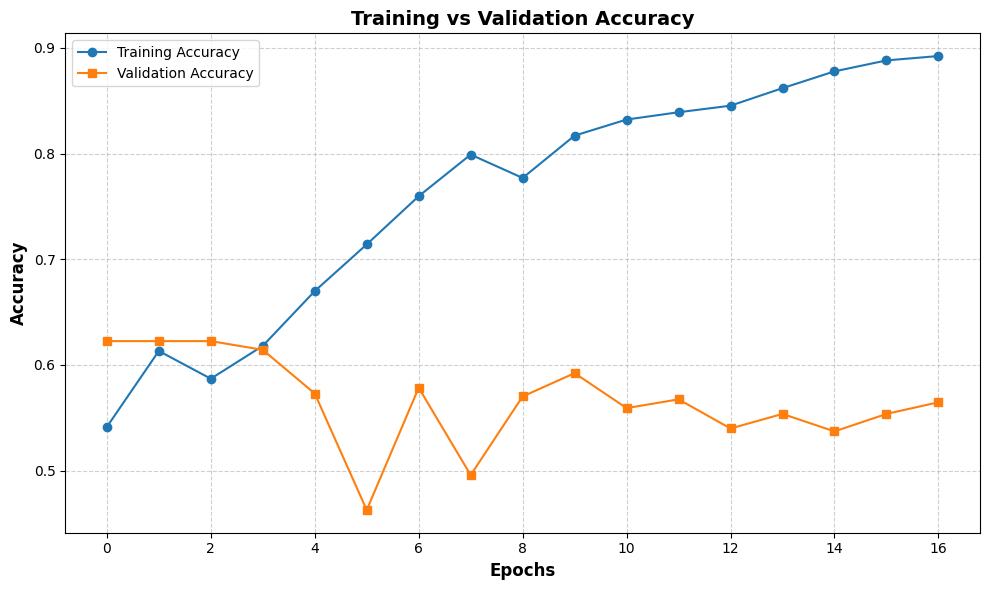

In [27]:
# --- Visualization 3: Training and Validation Accuracy over Epochs ---
try:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    plt.title('Training vs Validation Accuracy', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12, weight='bold')
    plt.ylabel('Accuracy', fontsize=12, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting accuracy graph: {e}")


##  LSTM model and Woord2Vec Train vs Validation

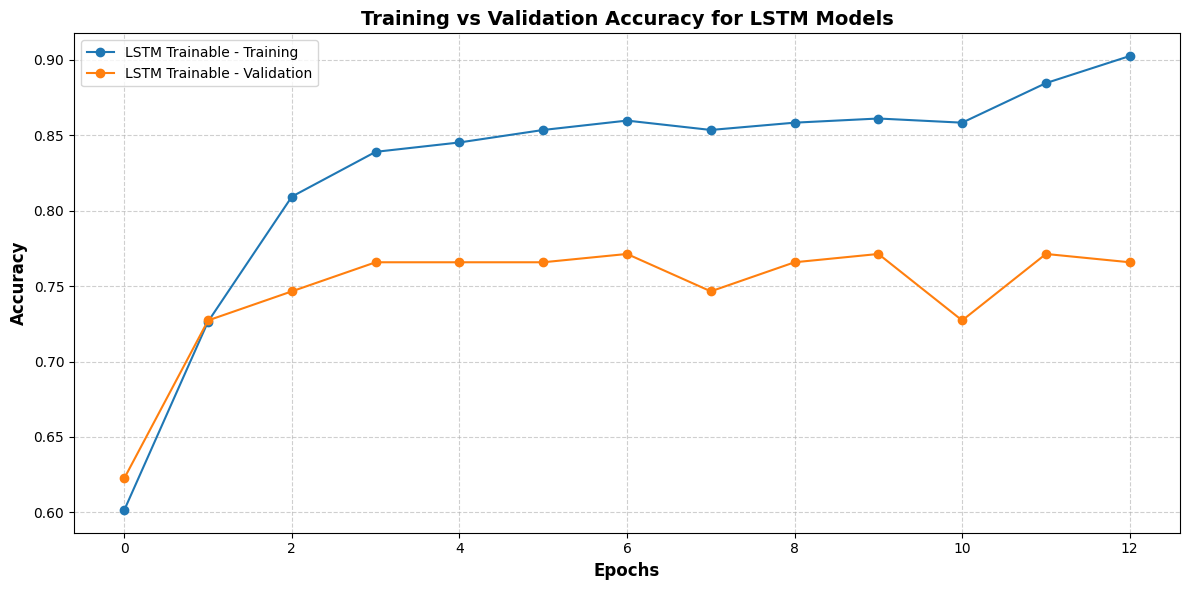

In [29]:
# --- Visualization: Training and Validation Accuracy for LSTM models ---
try:
    plt.figure(figsize=(12, 6))

    # LSTM with trainable embedding
    plt.plot(lstm_trainable_history.history['accuracy'], label='LSTM Trainable - Training', marker='o')
    plt.plot(lstm_trainable_history.history['val_accuracy'], label='LSTM Trainable - Validation', marker='o')


    plt.title('Training vs Validation Accuracy for LSTM Models', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12, weight='bold')
    plt.ylabel('Accuracy', fontsize=12, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error plotting LSTM accuracy comparison: {e}")


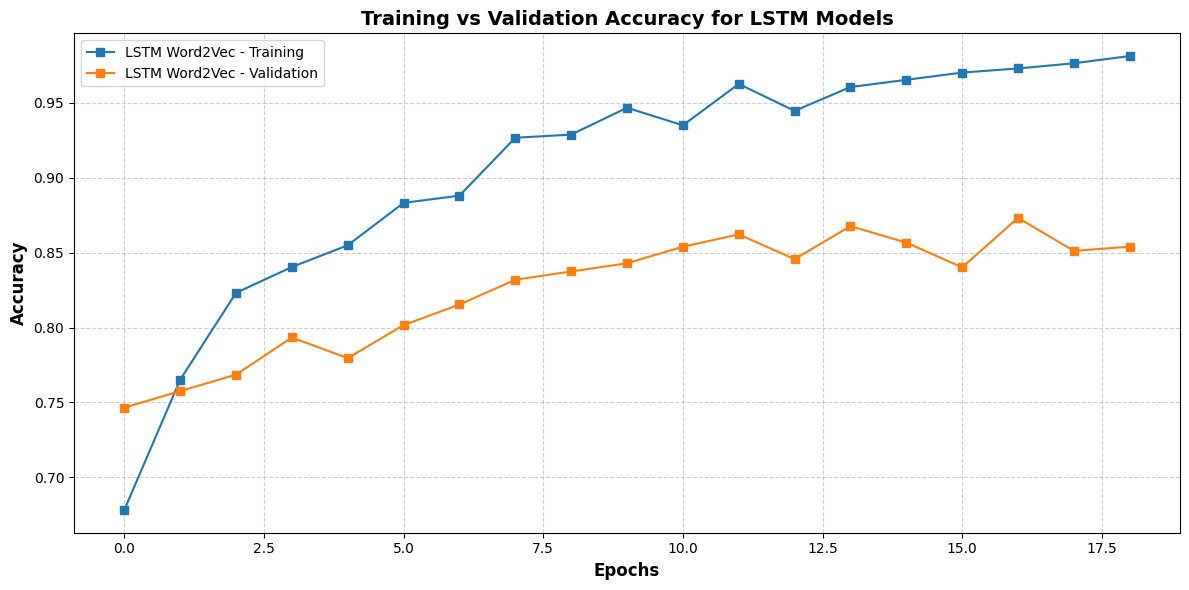

In [30]:
# --- Visualization: Training and Validation Accuracy for LSTM models ---
try:
    plt.figure(figsize=(12, 6))

    # LSTM with Word2Vec embedding
    plt.plot(lstm_word2vec_history.history['accuracy'], label='LSTM Word2Vec - Training', marker='s')
    plt.plot(lstm_word2vec_history.history['val_accuracy'], label='LSTM Word2Vec - Validation', marker='s')

    plt.title('Training vs Validation Accuracy for LSTM Models', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12, weight='bold')
    plt.ylabel('Accuracy', fontsize=12, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error plotting LSTM accuracy comparison: {e}")


## Define Prediction Function

Define a function to predict sentiment for a single tweet.

In [24]:
def predict_tweet_sentiment(tweet_text, model, tokenizer, max_sequence_length):
    """Predict the sentiment of a single tweet.

    Args:
        tweet_text (str): The tweet to analyze.
        model (Model): The trained model for sentiment prediction.
        tokenizer (Tokenizer): The tokenizer for text preprocessing.
        max_sequence_length (int): The maximum length for sequence padding.

    Returns:
        str: The predicted sentiment ('Negative', 'Neutral', or 'Positive').

    Raises:
        Exception: If prediction fails.
    """
    try:
        # Preprocess tweet
        cleaned_tweet = preprocess_text(tweet_text)

        # Convert to sequence
        sequence = tokenizer.texts_to_sequences([cleaned_tweet])

        # Pad sequence
        padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')

        # Predict sentiment
        prediction = model.predict(padded, verbose=0)

        # Get sentiment label
        sentiment_label = np.argmax(prediction, axis=1)[0]
        sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

        return sentiment_map[sentiment_label]

    except Exception as e:
        # Log prediction error
        return f"Error in prediction: {e}"

## Define Gradio Interface

Define a Gradio interface for real-time sentiment predictions using the best model (LSTM with Word2Vec).

In [25]:
def gradio_sentiment_interface(tweet_text):
    """Gradio interface for predicting tweet sentiment.

    Args:
        tweet_text (str): The tweet to analyze.

    Returns:
        str: The predicted sentiment or an error message.

    Raises:
        Exception: If the interface fails.
    """
    try:
        # Select the best model
        best_model = models['LSTM Word2Vec']

        # Validate input
        if not tweet_text:
            return "Error: Please enter a tweet."

        # Predict sentiment
        sentiment = predict_tweet_sentiment(tweet_text, best_model, tokenizer, max_sequence_length)

        return f"Predicted Sentiment: {sentiment}"

    except Exception as e:
        # Log interface error
        return f"Error in Gradio interface: {e}"

## Launch Gradio Interface

Launch the Gradio interface for interactive sentiment analysis.

In [ ]:
# Launch Gradio interface
try:
    gradio_iface = gr.Interface(
        fn=gradio_sentiment_interface,
        inputs=gr.Textbox(label="Enter Tweet", placeholder="Type your tweet here..."),
        outputs=gr.Textbox(label="Sentiment Prediction"),
        title="Financial Tweet Sentiment Analysis",
        description="Enter a tweet to predict its sentiment (Negative, Neutral, or Positive)."
    )
    gradio_iface.launch(share=True, debug=True)
except Exception as e:
    # Log Gradio launch error
    print(f"Error launching Gradio interface: {e}")

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a86300a6119a0ee43a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Conclusion

This notebook provides a complete pipeline for sentiment analysis of financial phrases or tweets. It includes data preprocessing, tokenization, training of three models (Simple RNN, LSTM with trainable Embedding, and LSTM with Word2Vec), evaluation with independent visualizations (confusion matrices, classification metrics, and accuracy comparison), and a Gradio interface for real-time predictions. Future enhancements could include hyperparameter tuning, additional visualizations (e.g., word clouds), or deploying the interface permanently on Hugging Face Spaces.